# Import

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from google.colab import drive




# Get data from google drive

In [ ]:
drive.mount('/content/drive')


from google.colab import files
uploaded = files.upload()

# Load the dataset from an Excel file
#df=pd.read_csv('Hang Seng.csv')
#df=pd.read_csv('DJIA.csv')
#df=pd.read_csv('Nikkei.csv')
#df=pd.read_csv('S&P500.csv')
df=pd.read_csv('Aria.csv')

df=df.values

open_price=df[:,2]
highest_price=df[:,3]
lowest_price=df[:,4]
close_price=df[:,5]
volume=df[:,6]

Mounted at /content/drive


Saving Aria.csv to Aria.csv


# LSTM Without Denoising

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:382: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:382: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


Epoch 1/50
10/10 [==============================] - 3s 33ms/step - loss: 0.0770
Epoch 2/50
10/10 [==============================] - 0s 30ms/step - loss: 0.0243
Epoch 3/50
10/10 [==============================] - 0s 29ms/step - loss: 0.0131
Epoch 4/50
10/10 [==============================] - 0s 31ms/step - loss: 0.0085
Epoch 5/50
10/10 [==============================] - 0s 30ms/step - loss: 0.0068
Epoch 6/50
10/10 [==============================] - 0s 30ms/step - loss: 0.0064
Epoch 7/50
10/10 [==============================] - 0s 29ms/step - loss: 0.0059
Epoch 8/50
10/10 [==============================] - 0s 31ms/step - loss: 0.0056
Epoch 9/50
10/10 [==============================] - 1s 51ms/step - loss: 0.0055
Epoch 10/50
10/10 [==============================] - 1s 54ms/step - loss: 0.0052
Epoch 11/50
10/10 [==============================] - 1s 53ms/step - loss: 0.0049
Epoch 12/50
10/10 [==============================] - 1s 58ms/step - loss: 0.0048
Epoch 13/50
10/10 [==================

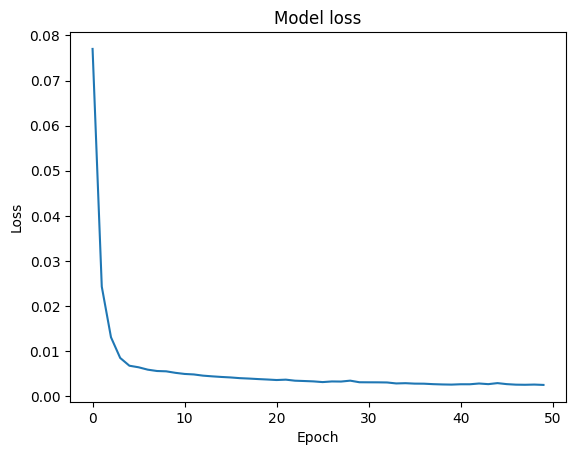

2/2 [==============================] - 0s 11ms/step


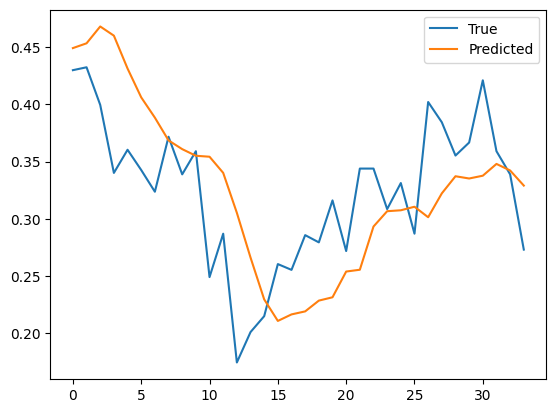

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data, test_data = df[0:train_size], df[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(train_data[1:, 2:7])
scaled_train_data = imputer.transform(train_data[1:, 2:7])
imputer = imputer.fit(test_data[1:, 2:7])
scaled_test_data = imputer.transform(test_data[1:, 2:7])

normalized_train = scaler.fit_transform(scaled_train_data)
normalized_test = scaler.fit_transform(scaled_test_data)
normalized_actual_test_close_price=normalized_test[:,4]
#normalized_test_actual=

# Define the input and output data

def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_train, y_train = create_dataset(normalized_train, normalized_train, time_steps)
X_test, y_test = create_dataset(normalized_test,normalized_test, time_steps)
y_train=y_train[:,3:4]
y_test=y_test[:,3:4]
Actual=y_test


#  Define a model
model = Sequential()
model.add(LSTM(50, input_shape=(None, 5)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train, epochs=50, batch_size=32)

# Plot the loss during training
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

y_pred_with_noise = model.predict(X_test)

plt.show()
plt.plot(y_test, label='True')
plt.plot(y_pred_with_noise, label='Predicted')
plt.legend()
plt.show()

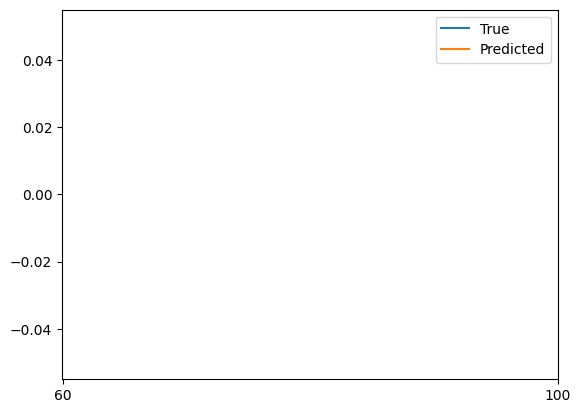

In [ ]:
start_index = 60
end_index = 100

plt.show()
plt.plot(y_test[start_index:end_index], label='True')
plt.plot(y_pred_with_noise[start_index:end_index], label='Predicted')

x_labels = list(range(start_index, end_index))
plt.xticks(range(len(x_labels)), x_labels)


plt.xticks([0, end_index - start_index], [start_index, end_index])
plt.legend()
plt.show()


# Kalman Filter for Denoising

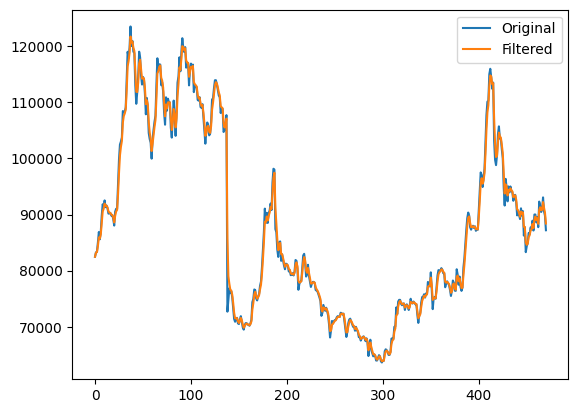

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import inv

# Define the system model and measurement equation
def f(x, u):
    # State transition function
    return x

def h(x):
    # Measurement function
    return x

# Define the Jacobians of the system and measurement functions
def F(x, u):
    # Jacobian of f with respect to x
    return np.eye(len(x))

def H(x):
    # Jacobian of h with respect to x
    return np.eye(len(x))

# Define the process and measurement noise covariances
Q = np.diag([0.1, 0.1, 0.1, 0.1, 0.1])
R = np.diag([0.1, 0.1, 0.1, 0.1,0.1])

# Define the initial state and covariance
x0 = np.array([open_price[0], highest_price[0], lowest_price[0], close_price[0], volume[0]])
P0 = np.diag([1, 1, 1, 1, 1])

# Create arrays to store the filtered state and covariance
N = len(open_price)
x = np.zeros((N, 5))
P = np.zeros((N, 5, 5))

# Initialize the filtered state and covariance
x[0] = x0
P[0] = P0

# Apply the EKF to the financial data
for i in range(1, N):
    # Predict the state and covariance
    x_pred = f(x[i-1], u=None)
    P_pred = F(x[i-1], u=None) @ P[i-1] @ F(x[i-1], u=None).T + Q

    # Update the state and covariance
    y = np.array([open_price[i], highest_price[i], lowest_price[i], close_price[i], volume[i]]) - h(x_pred)
    S = H(x_pred) @ P_pred @ H(x_pred).T + R
    K = P_pred @ H(x_pred).T @ inv(S)
    x[i] = x_pred + K @ y
    P[i] = (np.eye(5) - K @ H(x_pred)) @ P_pred

# Plot the original and filtered data
plt.plot(close_price, label='Original')
plt.plot(x[:, 3], label='Filtered')
plt.legend()
plt.show()



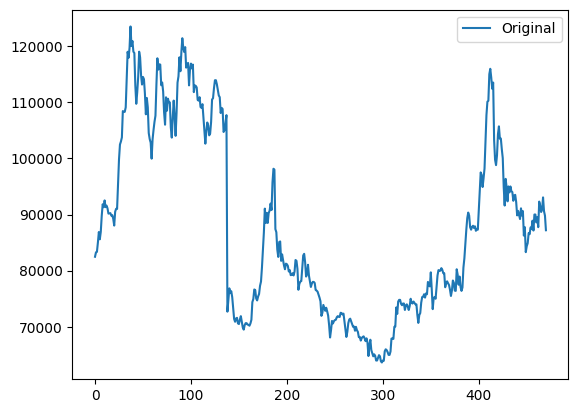

In [ ]:
plt.plot(close_price, label='Original')
#plt.plot(x[:, 3], label='Filtered')
plt.legend()
plt.show()

# LSTM with Denoising

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:382: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:382: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


Epoch 1/50
10/10 [==============================] - 6s 91ms/step - loss: 0.0281
Epoch 2/50
10/10 [==============================] - 1s 90ms/step - loss: 0.0099
Epoch 3/50
10/10 [==============================] - 1s 63ms/step - loss: 0.0070
Epoch 4/50
10/10 [==============================] - 1s 71ms/step - loss: 0.0046
Epoch 5/50
10/10 [==============================] - 1s 66ms/step - loss: 0.0041
Epoch 6/50
10/10 [==============================] - 1s 69ms/step - loss: 0.0038
Epoch 7/50
10/10 [==============================] - 1s 69ms/step - loss: 0.0036
Epoch 8/50
10/10 [==============================] - 1s 65ms/step - loss: 0.0035
Epoch 9/50
10/10 [==============================] - 1s 58ms/step - loss: 0.0032
Epoch 10/50
10/10 [==============================] - 1s 66ms/step - loss: 0.0030
Epoch 11/50
10/10 [==============================] - 1s 60ms/step - loss: 0.0028
Epoch 12/50
10/10 [==============================] - 1s 81ms/step - loss: 0.0027
Epoch 13/50
10/10 [==================

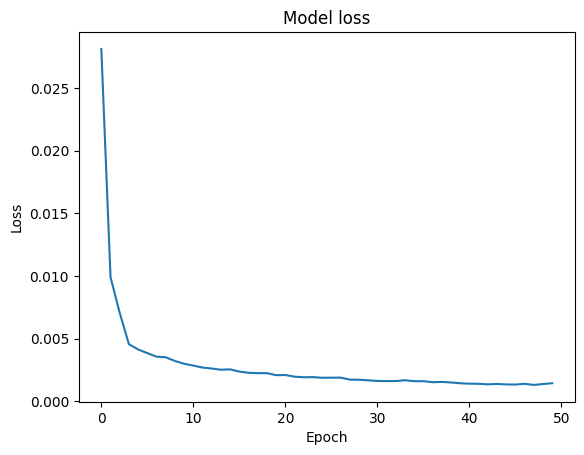

2/2 [==============================] - 0s 11ms/step


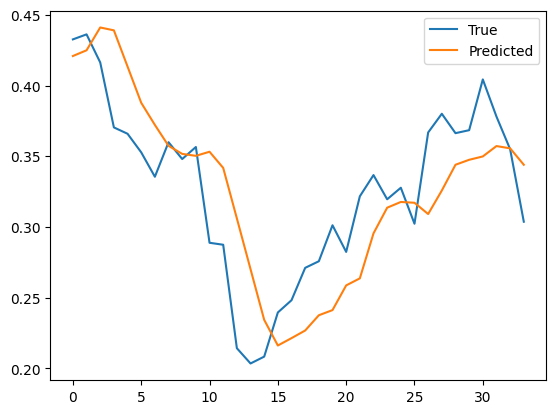

In [ ]:
# Split the dataset into training and testing sets
#train_size=300
#test_size=100
#test_size = len(x) - train_size
#train_data, test_data = x[0:train_size], x[train_size+1:train_size+test_size]

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data, test_data = x[0:train_size], x[train_size:len(df)]



# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(train_data[1:, :])
scaled_train_data = imputer.transform(train_data[1:, :])
imputer = imputer.fit(test_data[1:, :])
scaled_test_data = imputer.transform(test_data[1:,:])

normalized_train = scaler.fit_transform(scaled_train_data)
normalized_test = scaler.fit_transform(scaled_test_data)


def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_train, y_train = create_dataset(normalized_train, normalized_train, time_steps)
X_test, y_test = create_dataset(normalized_test,normalized_test, time_steps)
y_train=y_train[:,3:4]
y_test=y_test[:,3:4]

#  Define a model
model = Sequential()
model.add(LSTM(50, input_shape=(None, 5)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train, epochs=50, batch_size=32)

# Plot the loss during training
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

y_pred_without_noise = model.predict(X_test)

plt.show()
plt.plot(y_test, label='True')
plt.plot(y_pred_without_noise, label='Predicted')
plt.legend()
plt.show()


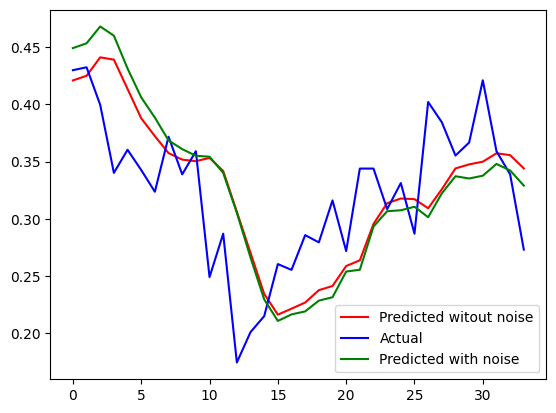

In [ ]:

plt.plot(y_pred_without_noise, label='Predicted witout noise',color='red')
plt.plot(Actual, label='Actual',color='blue')
#plt.plot(normalized_actual_test_close_price, label='Actual',color='blue')
plt.plot(y_pred_with_noise, label='Predicted with noise',color='green')



plt.legend()

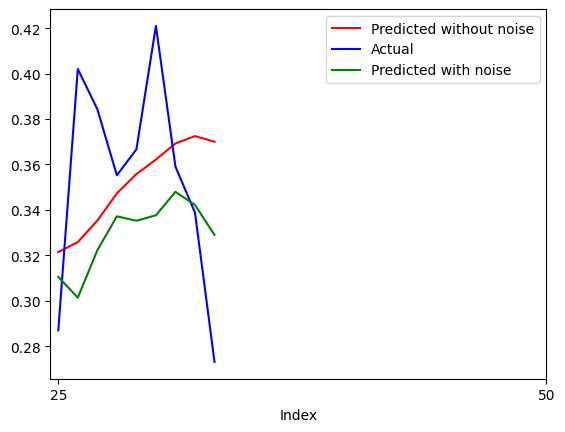

In [ ]:
start_index = 0
end_index = 50

plt.plot(y_pred_without_noise[start_index:end_index], label='Predicted without noise', color='red')
plt.plot(Actual[start_index:end_index], label='Actual', color='blue')
plt.plot(y_pred_with_noise[start_index:end_index], label='Predicted with noise', color='green')

x_labels = list(range(start_index, end_index))
plt.xticks(range(len(x_labels)), x_labels)


plt.xticks([0, end_index - start_index], [start_index, end_index])

plt.legend()
plt.xlabel('Index')
plt.show()


In [ ]:
import numpy as np

# MAPE
n = y_test.shape[0]
epsilon = 0.01 # set a small epsilon value
y_test_mod = np.where(y_test==0, epsilon, y_test) # replace zeros with epsilon
mape = (1/n) * np.sum(np.abs((y_test_mod - y_pred_without_noise)/y_test_mod))
print('MAPE wihtout noise:',mape)
mape = (1/n) * np.sum(np.abs((y_test_mod - y_pred_with_noise)/y_test_mod))
print('MAPE wiht noise:',mape)

# theil u
theil_u = np.sqrt((1/n) * np.sum((y_pred_without_noise - y_test_mod)**2) / np.sum(y_test_mod**2))
print('Theil U without noise:', theil_u)
theil_u = np.sqrt((1/n) * np.sum((y_pred_with_noise - y_test_mod)**2) / np.sum(y_test_mod**2))
print('Theil U with noise:', theil_u)

# RMSE
rmse = np.sqrt(np.mean((y_pred_without_noise - y_test)**2))
print('RMSE without noise:', rmse)
rmse = np.sqrt(np.mean((y_pred_with_noise - y_test)**2))
print('RMSE with noise:', rmse)

#

MAPE wihtout noise: 0.11459263188644989
MAPE wiht noise: 0.13268794596278136
Theil U without noise: 0.021212333636404308
Theil U with noise: 0.024402350304816033
RMSE without noise: 0.04115542232610325
RMSE with noise: 0.04734458026912568
